# Read data

In [1]:
import os
import numpy as np
import cv2
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

2024-05-04 00:52:04.889116: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-04 00:52:04.997856: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-04 00:52:05.556752: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 00:52:08.688815: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Hàm đọc ảnh từ folder và tiền xử lý
def load_and_preprocess_data(folder_path, img_size=(150, 150)):
    images = []
    labels = []
    label_encoder = LabelEncoder()
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        for img_file in os.listdir(label_path):
            img_path = os.path.join(label_path, img_file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype("float32") / 255.0
            images.append(img)
            labels.append(label)
    labels = label_encoder.fit_transform(labels)
    return np.array(images), np.array(labels)


# Hàm chuẩn hóa dữ liệu
def normalize_data(train_data, val_data, test_data):
    mean = np.mean(train_data, axis=0)
    std = np.std(train_data, axis=0)
    train_data = (train_data - mean) / std
    val_data = (val_data - mean) / std
    test_data = (test_data - mean) / std
    return train_data, val_data, test_data, mean, std


# Hàm giảm chiều dữ liệu bằng PCA
def apply_pca(train_data, val_data, test_data, n_components=225):
    pca = PCA(n_components=n_components)
    pca.fit(train_data)
    train_data_pca = pca.transform(train_data)
    val_data_pca = pca.transform(val_data)
    test_data_pca = pca.transform(test_data)
    return train_data_pca, val_data_pca, test_data_pca, pca

In [3]:
# Load dữ liệu
train_images, train_labels = load_and_preprocess_data("datav2/train")
val_images, val_labels = load_and_preprocess_data("datav2/validation")
# test_images, test_labels = load_and_preprocess_data("datav2/test")

# Tiền xử lý data. 

## Chuẩn hóa

In [4]:
mean = np.mean(train_images, axis=0)
std = np.std(train_images, axis=0)

In [5]:
train_images /= std

In [6]:
val_images /= std 

In [7]:
train_images = train_images.reshape(train_images.shape[0], -1)

In [8]:
train_images.shape

(5000, 67500)

In [9]:
val_images = val_images.reshape(val_images.shape[0], -1)

In [10]:
val_images.shape

(2500, 67500)

## Giảm số chiều PCA 

In [11]:
n_components = 225
pca = PCA(n_components=n_components)
pca.fit(train_images) 

PCA(n_components=225)

In [12]:
# Lưu lại thông tin chuẩn hóa và PCA
with open("preprocessing_info_datav2.pkl", "wb") as f:
    pickle.dump((mean, std, pca), f)

In [13]:
train_images = pca.transform(train_images)

In [14]:
val_images = pca.transform(val_images)

In [15]:
print(train_images.shape, val_images.shape)

(5000, 225) (2500, 225)


In [16]:
import numpy as np

# Lưu train data
np.save('train_images_datav2.npy', train_images)
np.save('train_labels_datav2.npy', train_labels)

# Lưu validation data
np.save('val_images_datav2.npy', val_images)
np.save('val_labels_datav2.npy', val_labels)

In [19]:
# Xây dựng mô hình ANN
model = models.Sequential(
    [
        layers.InputLayer(shape=(225,)),
        layers.Dense(256 * 2, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(256, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(10, activation="softmax"),
    ]
)

In [20]:
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [22]:
# Callback để lưu lại model có accuracy cao nhất trên tập validation
checkpoint = callbacks.ModelCheckpoint(
    "best_model_datav2.keras", monitor="val_accuracy", save_best_only=True, mode="max"
)

In [23]:
# Huấn luyện mô hình
history = model.fit(
    train_images,
    train_labels,
    epochs=20,
    # validation_data=(val_images, val_labels),
    callbacks=[checkpoint],
)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.2594 - loss: 2.6440
Epoch 2/20
 10/157 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4728 - loss: 1.6025

/home/harito/venv/ai_env_3.11/lib/python3.11/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4621 - loss: 1.6082
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5288 - loss: 1.3277
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5839 - loss: 1.1207
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5997 - loss: 1.0155
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6630 - loss: 0.8773
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6986 - loss: 0.7918
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7291 - loss: 0.7088
Epoch 9/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7533 - loss: 0.6683
Epoch 10/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7839 - loss: 0.5863
Epoch 11/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7950 - loss: 0.5436
Epoch 12/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8221 - loss: 0.4634
Epoch 13/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/st

In [27]:
# Biểu đồ lịch sử huấn luyện
def plot_training_history(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


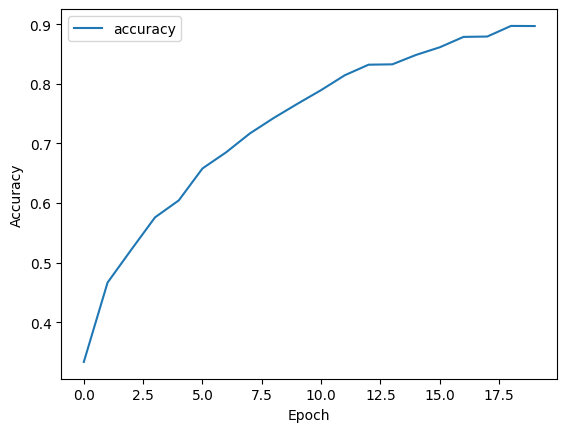

In [28]:
plot_training_history(history)

In [26]:
# Đánh giá mô hình trên tập val
val_loss, val_acc = model.evaluate(val_images, val_labels)
print("Val accuracy:", val_acc)

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4502 - loss: 2.1094
Val accuracy: 0.5651999711990356
